<h1> Ligand Conformational Analysis Tutorial</h1>

<h3>In this tuturial we want to demonstrate how to analyze molecular conformations which are very important for ligand design. We will compute conformations with a fast, knowledge-based method and compare the conformations to solution structures of the molecule sampled in a MD simulation</h3>

In [55]:
pwd

'/home/dseelig/code/ITNLecture/notebooks'

<h3>The next lines import some modules we need for the analysis</h3>

In [75]:
import pyemma
%pylab inline
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
from glob import glob
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Geometry import rdGeometry
from IPython.display import SVG
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing, DrawingOptions
from ipywidgets import interactive, VBox, interact, IntSlider
import nglview as nv
IPythonConsole.ipython_useSVG=True
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.molSize = 400,400

Populating the interactive namespace from numpy and matplotlib


<h4> We need to define a number functions which we need for the analysis.</h4>

In [3]:
def smooth(x, window_len=11, window='hanning'):
    
    s = r_[2*x[0]-x[window_len:1:-1],x,2*x[-1]-x[-1:-window_len:-1]]
    w = eval( window+'(window_len)')
    y = convolve(w/w.sum(),s,mode='same')
    return y[window_len-1:-window_len+1]

In [4]:
def rmsd(m1, m2):
    rd = 0
    tm = float( len( m1.atoms ) )
    for a1, a2 in zip(m1.atoms,m2.atoms):
        for i in range(3):
            xd = a1.x[i] - a2.x[i]
            rd+= xd*xd
    return np.sqrt(rd/tm)

In [5]:
def plot_free_energy(xall, yall, weights=None, ax=None, nbins=100, offset=0.1, range=((-180,180),(-180,180)),
                     cmap='coolwarm_r', cbar=True, cbar_label='Free energy (kT)'):

    z, x, y = np.histogram2d(xall, yall, bins=nbins, weights=weights, range = range)
    z += offset
    # compute free energies
    F = -np.log(z)
    # do a contour plot
    extent = [x[0], x[-1], y[0], y[-1]]
    if ax is None:
        ax = gca()
    CS = ax.contourf(F.T, 100, extent=extent, cmap=cmap)
    if cbar:
        cbar = colorbar(CS)
        if cbar_label is not None:
            cbar.ax.set_ylabel(cbar_label)

    return ax, gcf()


In [6]:
def computeDihedralAngle(mol, indices, conf_id = 0):
    c = mol.GetConformer(conf_id)
    pos = []
    for idx in indices:
        pos.append(c.GetAtomPosition(idx))
    phi = rdGeometry.ComputeSignedDihedralAngle(pos[0], pos[1], pos[2],pos[3])*180/np.pi
    return phi

def dihedralsFromConformers(mol, dih_list):
    mtx = np.zeros((len(list(mol.GetConformers())), len(dih_list)))
    for i, c in enumerate(list(mol.GetConformers())):
        for k, indices in enumerate(dih_list):
            v = computeDihedralAngle(mol, indices, conf_id = i)
            mtx[i,k] = v
    return mtx

In [45]:
def drawDihedrals(mol, lst):
    DrawingOptions.includeAtomNumbers = False
    DrawingOptions.elemDict = {0:[0.5,0.5,0.5]}
    DrawingOptions.bondLineWidth = 1.5
    DrawingOptions.atomLabelFontSize = 16
    return Draw.MolsToGridImage([mol,mol,mol,mol],highlightAtomLists = [lst[0],lst[1],lst[2],lst[3]], subImgSize=(300,300), legends=['Dihdral 1','Dihedral 2','Dihedral 3','Dihedral 4'])        

In [50]:
def drawMoleculeWithAtomIndices(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol    

In [72]:
class LigandViewer():
    
    def __init__(self, mol):
        self.mol = mol
        self.view = nv.NGLWidget()
        s = nv.RdkitStructure(self.mol, conf_id = 1)
        self.c = self.view.add_component(s)
        
    def show_conformer(self, idx):
        if self.c is not None:
            self.view.remove_component(self.c)
        new_id = idx.new
        s = nv.RdkitStructure(self.mol, conf_id = new_id)
        self.c = self.view.add_component(s)
        


<h3> Now let's start with the actual tutorial. We load molecule and define dihedral angles we would like to use for the analysis</h3>

<h4> Load molecule from a directory and compute 2D coordinates</h4>

In [57]:
mol = Chem.MolFromMolFile('../data/ligand_md/ligand.sdf', removeHs=False)
_=AllChem.Compute2DCoords(mol)

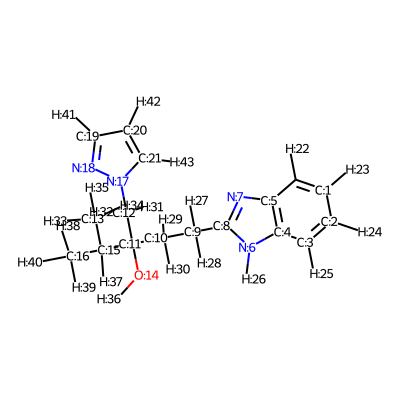

In [58]:
drawMoleculeWithAtomIndices(mol)

<h3> Now let's define the dihedral angles by their atom indices and highlight the respective atoms in the structure</h3>

In [59]:
lst = []
lst.append( [7,8,9,10] )
lst.append( [8,9,10,11] )
lst.append( [9,10,11,14] )
lst.append( [14,11,12,17] )

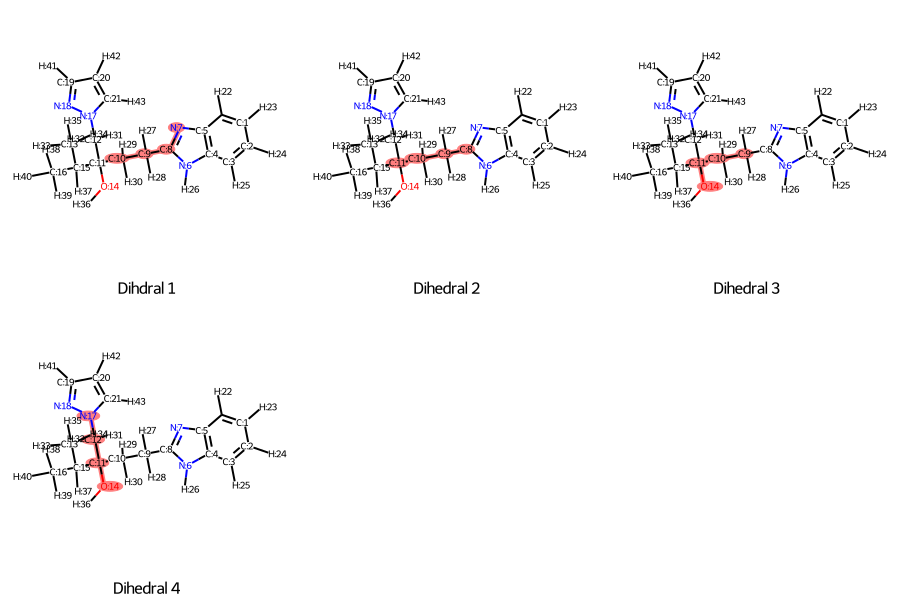

In [60]:
drawDihedrals(mol, lst)

<h3> Conformer Generation</h3>
<h4> We load the molecule again and use a knowledge-based method to compute 20 conformers</h4>

In [61]:
mol2 = Chem.MolFromMolFile('../data/ligand_md/ligand.sdf', removeHs = False)
_ = AllChem.EmbedMultipleConfs(mol2, numConfs = 20)

In [11]:
mtx = dihedralsFromConformers(mol2, lst)

<h4> Now we plot the 4 dihedrals for each conformer </h4>

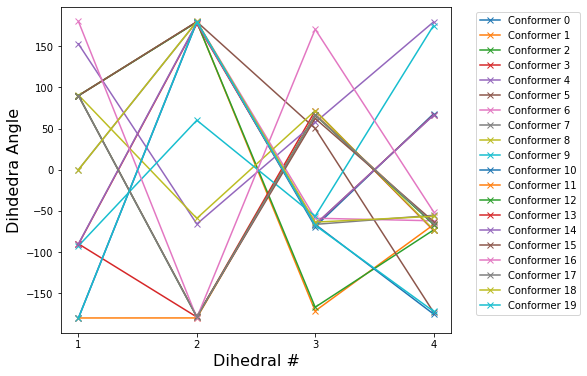

In [70]:
figure(figsize=(7,6))
for i in range(20):
    plot(mtx[i],'x-', label='Conformer %d' % i)
xticks(range(4), range(1,5))
xlabel('Dihedral #', fontsize=16)
ylabel('Dihdedra Angle', fontsize=16)
legend(bbox_to_anchor=(1.05, 1));
#plot(mtx[:,0],mtx[:,1],'kx')

<h4> Let's have a look at he conformers in 3D</h4>

In [78]:
viewer = LigandViewer(mol2)
slider = IntSlider(min=0,max=len(list(mol2.GetConformers()))-1)

slider.observe(viewer.show_conformer, 'value')
VBox([viewer.view, slider])

<h3> In the next step we load trajectories from molecular dynamics simulations of the molecule. The data is stored in the repository. We get the paths of the trajectories into a list and also require a reference pdb file</h3>

In [96]:
from glob import glob
traj_list = glob('../data/ligand_md/*.xtc')
topfile = '../data/ligand_md/ligand.pdb'
print(traj_list)

['../data/ligand_md/run1.xtc', '../data/ligand_md/run3.xtc', '../data/ligand_md/run0.xtc', '../data/ligand_md/run2.xtc', '../data/ligand_md/run4.xtc']


<h4> In order to read trajectory data we need initialize a feature reader with a correct topology file which contains the molecule.</h4>

In [97]:
# pdb file
feat = coor.featurizer(topfile)

<h4> then we tell the featurizer which dihedrals we are interested in.</h4>

In [98]:
feat.add_dihedrals(lst)

<h4> In the next step we extract the features from the trajectories<h4>

In [99]:
inp = coor.load(traj_list, feat)

Obtaining file info:   0%|                                                                                    …

getting output of FeatureReader:   0%|                                                                        …

<h3> inp is a list of arrays containing the extracted features. inp[0] contains the data from the first trajectory, inp[-1] the data from the last.</h3> 

In [100]:
#inp

<h3> Now let's have a look at the distribution of the dihedral angle 1 </h3>

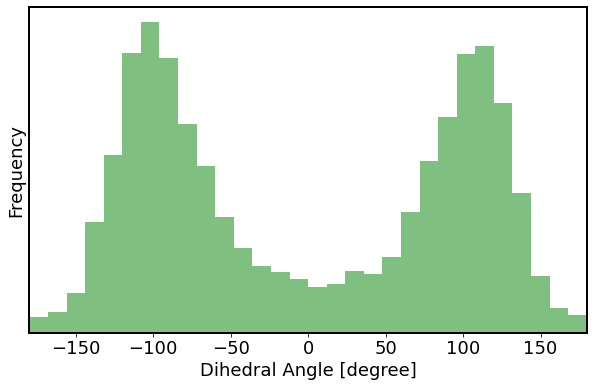

In [101]:
figure(figsize=(10,6))
n, b, p = hist(np.vstack(inp)[:,0]*180./pi, bins=30, color = 'g', alpha=.5)
for p in gca().spines.values(): p.set_lw(2)
yticks([]);
xlim(-180,180);
xticks(fontsize=18);
xlabel('Dihedral Angle [degree]', fontsize=18);
ylabel('Frequency', fontsize=18);
#plot([ref,ref],[0,max(n)*.7],'k-')
#text(ref-40, max(n)*.8,'Xray Dihedral', fontsize=16)

<h3> .. and dihedral angle 2. </h3>

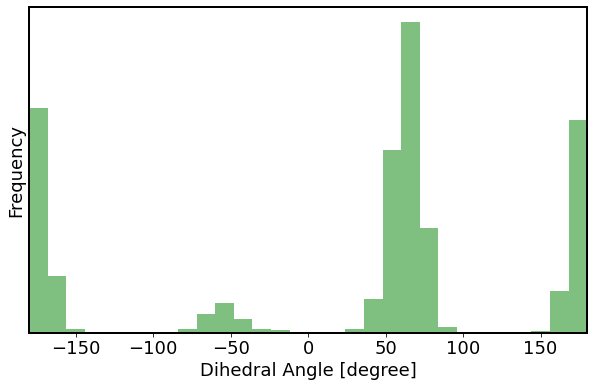

In [102]:
figure(figsize=(10,6))
n, b, p = hist(np.vstack(inp)[:,3]*180./pi, bins=30, color = 'g', alpha=.5)
for p in gca().spines.values(): p.set_lw(2)
yticks([]);
xlim(-180,180);
xticks(fontsize=18);
xlabel('Dihedral Angle [degree]', fontsize=18);
ylabel('Frequency', fontsize=18);
#plot([ref,ref],[0,max(n)*.7],'k-')
#text(ref-40, max(n)*.8,'Xray Dihedral', fontsize=16)

<h4> We can use histogram data to obtain the free-energy profile along the coordinate. To this end we first fit a gaussian kernel to the histogram.</h4>

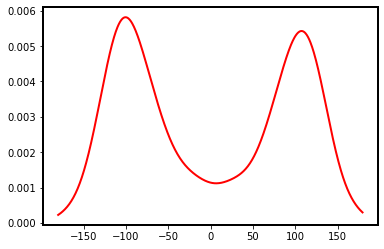

In [105]:
from scipy.stats import gaussian_kde
kernel = gaussian_kde(np.vstack(inp)[:,0]*180./pi)
xr = arange(-180, 180,.5)
y_kde = kernel.evaluate(xr)
plot(xr,y_kde,'r-',lw=2)
for p in gca().spines.values(): p.set_lw(2)

<h4> Then we can used the fitted data and convert it into a rotation energy profile</h4>

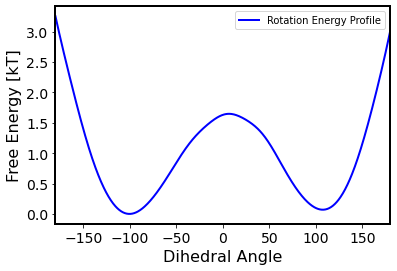

In [106]:
energy = -log(y_kde)
nenergy = energy - min( energy )
plot(xr, nenergy, 'b-',lw=2, label = 'Rotation Energy Profile')
xlim(-180,180)
xlabel('Dihedral Angle',fontsize=16)
ylabel('Free Energy [kT]',fontsize=16)
#grid(lw=2)
xticks( fontsize=14)
yticks( fontsize=14)
legend( loc='upper right')
for p in gca().spines.values(): p.set_lw(2)
#savefig('dihedral1_energy.png')

<h3> Now we plot a 2d histogram of the two dihedral angles.</h3>

(-180.0, 180.0)

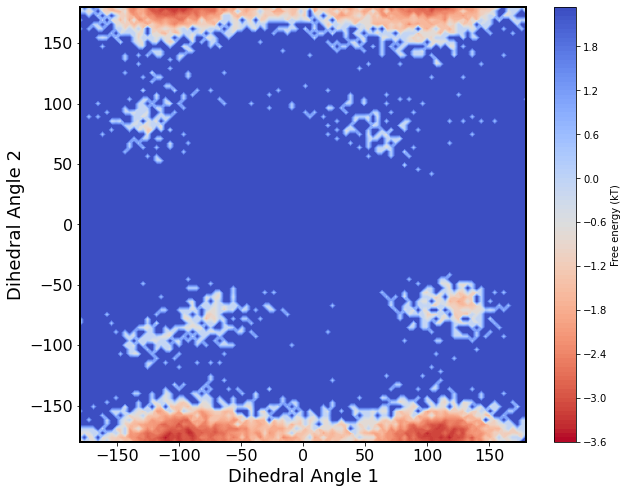

In [107]:
figure(figsize=(10,8))
#mplt.plot_free_energy(np.vstack(inp)[:,0]*180./pi,np.vstack(inp)[:,1]*180./pi, offset = 0.1)
plot_free_energy(np.vstack(inp)[:,0]*180./pi,np.vstack(inp)[:,1]*180./pi, offset = 0.1)
for p in gca().spines.values(): p.set_lw(2)
#plot(ref_1, ref_2,'ko', markersize=10)
#text(ref_1, ref_2+20,"Xray Dihedrals", fontsize=20)
xticks(fontsize=16)
yticks(fontsize=16)
xlabel('Dihedral Angle 1', fontsize=18)
ylabel('Dihedral Angle 2', fontsize=18)
xlim(-180,180)
ylim(-180,180)


<h4> and the same for dihedral angle 3 and 4</h4>

(-180.0, 180.0)

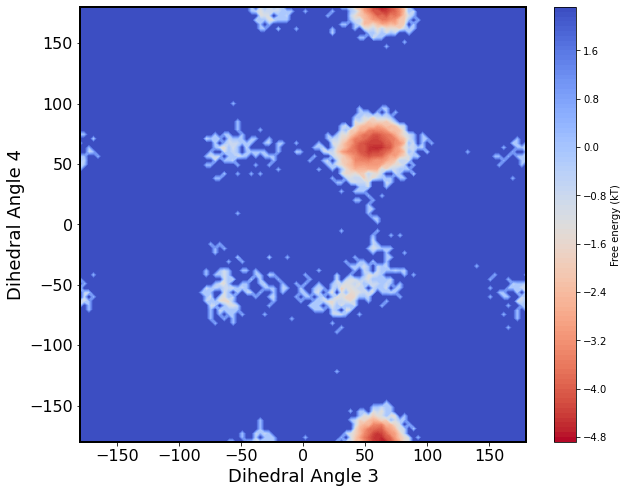

In [109]:
figure(figsize=(10,8))
#mplt.plot_free_energy(np.vstack(inp)[:,0]*180./pi,np.vstack(inp)[:,1]*180./pi, offset = 0.1)
plot_free_energy(np.vstack(inp)[:,2]*180./pi,np.vstack(inp)[:,3]*180./pi, offset = 0.1)
for p in gca().spines.values(): p.set_lw(2)
#plot(ref_1, ref_2,'ko', markersize=10)
#text(ref_1, ref_2+20,"Xray Dihedrals", fontsize=20)
xticks(fontsize=16)
yticks(fontsize=16)
xlabel('Dihedral Angle 3', fontsize=18)
ylabel('Dihedral Angle 4', fontsize=18)
xlim(-180,180)
ylim(-180,180)
#plot(mtx[:,0],mtx[:,1],'kx')
#savefig('dih3_vs_dih4.png', bbox_inches = 'tight')

<h3>Possible Exercises:</h3>
<h4> 1) Check if any internal H-bonds are formed in solution </h4>
<h4> 2) Which are the most revelant conformations in solution </h4>
<h4> 3) Analyze other dihedral angles. Are all rotatable bonds truly rotatable?</h4>

<h3> Clustering and Selection of Conformers</h3>

In [65]:
dist_lst = []
lst =  list(mol.GetAtoms())
for i, a1 in enumerate(lst[:-1]):
    for a2 in lst[i+1:]:
        dist_lst.append([a1.GetIdx(), a2.GetIdx()])

    

In [66]:
feat3 = coor.featurizer(topfile)
feat3.add_distances(dist_lst)
#feat3.describe()

In [67]:
inp = coor.load(traj_list, feat3)
source = coor.source( traj_list, top = topfile )

Obtaining file info:   0%|                                                                     | 0/5 [00:00<?,…

getting output of FeatureReader:   0%|                                                         | 0/5 [00:00<?,…

Obtaining file info:   0%|                                                                     | 0/5 [00:00<?,…

<h3> KMeans clustering on intramolecular distances</h3>

In [68]:
n_clusters = 20
cl_obj = coor.cluster_kmeans(inp, k=n_clusters)

initialize kmeans++ centers:   0%|                                                            | 0/20 [00:00<?,…

kmeans iterations:   0%|                                                                      | 0/10 [00:00<?,…

26-07-21 10:14:52 pyemma.coordinates.clustering.kmeans.KmeansClustering[3] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


In [69]:
# Generate samples from each cluster
samples = cl_obj.sample_indexes_by_cluster(range(n_clusters),1)
out_name_base = '../data/ligand_md/cluster'
out_names = []
for i in range(n_clusters):
    out_names.append( out_name_base+'%d.pdb' % i)
#print out_names

getting output of KmeansClustering:   0%|                                                      | 0/5 [00:00<?,…

In [70]:
# save cluster representatives
coor.save_trajs(source, samples, outfiles = out_names)



['../data/ligand_md/cluster0.pdb',
 '../data/ligand_md/cluster1.pdb',
 '../data/ligand_md/cluster2.pdb',
 '../data/ligand_md/cluster3.pdb',
 '../data/ligand_md/cluster4.pdb',
 '../data/ligand_md/cluster5.pdb',
 '../data/ligand_md/cluster6.pdb',
 '../data/ligand_md/cluster7.pdb',
 '../data/ligand_md/cluster8.pdb',
 '../data/ligand_md/cluster9.pdb',
 '../data/ligand_md/cluster10.pdb',
 '../data/ligand_md/cluster11.pdb',
 '../data/ligand_md/cluster12.pdb',
 '../data/ligand_md/cluster13.pdb',
 '../data/ligand_md/cluster14.pdb',
 '../data/ligand_md/cluster15.pdb',
 '../data/ligand_md/cluster16.pdb',
 '../data/ligand_md/cluster17.pdb',
 '../data/ligand_md/cluster18.pdb',
 '../data/ligand_md/cluster19.pdb']

<h3> Cluster Statistics</h3>

<h4> Generate 1-dim array of all discretized (assigned to a cluster) trajectories</h4>

In [71]:
ii = np.concatenate(cl_obj.dtrajs)
#ii = np.vstack(cl_obj.dtrajs).flatten()

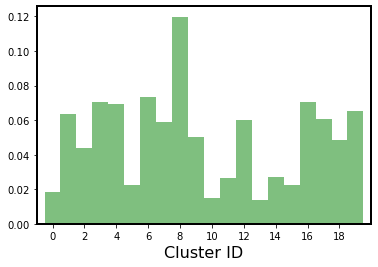

In [77]:
occupancy,b,p = hist(ii,bins=n_clusters,range=(-.5, 19.5),color='g',alpha=.5, density=True)
xlim(-1,n_clusters)
xticks( range(0,n_clusters,2))
xlabel('Cluster ID', fontsize=16)
for p in gca().spines.values(): p.set_lw(2)

In [74]:
lst  = glob('../data/ligand_md/cluster*.pdb')

In [ ]:
rmsd_mat = np.zeros( len(lst)**2).reshape( (len(lst),len(lst)))
for i, f1 in enumerate(lst[:-1]):
    for k, f2 in enumerate(lst[i+1:]):
        id1 = int(f1.split('.')[0].split('cluster')[1])
        id2 = int(f2.split('.')[0].split('cluster')[1])
        m1 = Model( f1 )
        m2 = Model( f2 )
        fit_atoms( m1.atoms, m2.atoms, m2.atoms )
        dd = rmsd( m1, m2 )
        rmsd_mat[id1][id2] = dd




In [ ]:
import networkx as nx
G = nx.Graph()
cutoff = 0.8
for i in range( n_clusters ):
    G.add_node(i)
for i in range( n_clusters-1 ):
    for k in range( i+1, n_clusters):
        rm = rmsd_mat[i][k]
        if rm <= cutoff:
            G.add_edge( i,k )
#            dic[i].append( k )
#            print i, k
#        print i, k, rmsd_mat[i][k]
print G#print dic   

In [ ]:
#nx.clustering(G)
#print occupancy
atoms_to_fit = ['C1','C2','C3']#,'C9']
ref_conf = Model('cluster0.pdb')
ref_atoms = ref_conf.residues[0].fetchm(atoms_to_fit)

cluster_lst = []
for cluster_ids in nx.connected_components(G):
    occ = 0
    for idx in cluster_ids:
        occ += occupancy[idx]
    cluster_lst.append( [cluster_ids, occ] )

sorted_cluster_lst =  sorted( cluster_lst, lambda a,b: cmp(b[1],a[1]) )


fpp = open('clusters_stats.txt','w')
for i, (ids, occ) in enumerate(sorted_cluster_lst):
    fp = open('MetaCluster%d.pdb' % i,'w')
    print >>fpp, 'MetaCluster%d.pdb -> Population = %4.2f%%' % (i,occ*100)
    for k, ii in enumerate(ids):
        fn = 'cluster%d.pdb' % ii
        m = Model(fn)
        atoms = m.residues[0].fetchm( atoms_to_fit )
        fit_atoms( ref_atoms, atoms, m.atoms )
        print >>fp, 'MODEL%5d' % k
        for atom in m.atoms:
            print >>fp, atom
        print >>fp, 'ENDMDL'
    fp.close()
fpp.close()


    #    print cluster_ids, occ